### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2022 Semester 2

## Assignment 1

**Student Name:**    `Philipp Habicht`

This iPython notebook is a template which you should use for your Assignment 3 submission. This file should be submitted at the **Assignment 3: Code** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a writren report explaining your results at the **Assignment 3: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 1. Load images and compute correspondences


In [1]:
from os import listdir
from os.path import isfile, join
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from random import sample

In [2]:
imgs = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in glob.glob("/Users/hawk/Documents/Unimelb/Computer Vision/CV_Assignment3/kusvod2/*g")]

In [3]:
len(imgs)

32

In [28]:
img1 = imgs[4]
img2 = imgs[8]

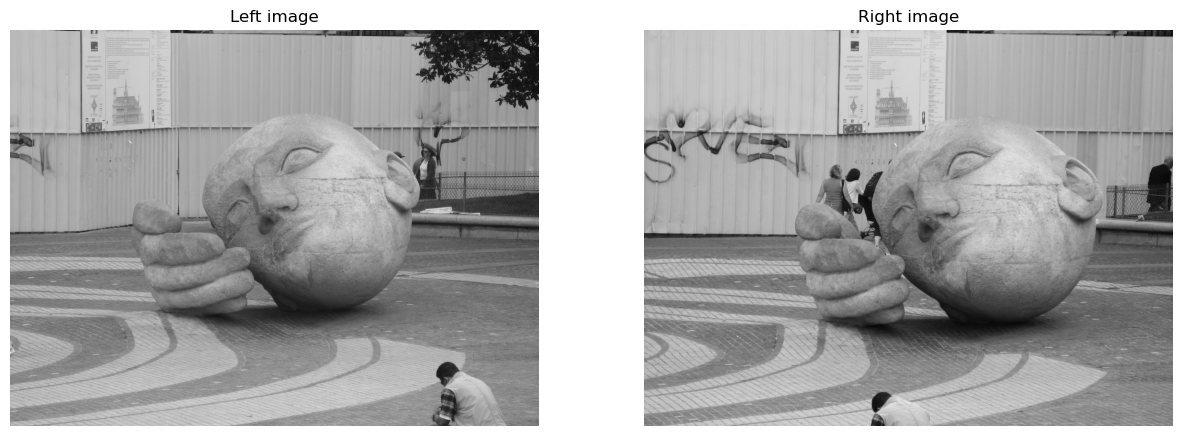

In [29]:
# Display the images
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray')  
plt.title('Left image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2, cmap='gray')  
plt.title('Right image')
plt.axis('off')

plt.show()

In [30]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# Compute SIFT keypoints and descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# FLANN parameters and initialize
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching descriptor using KNN algorithm
matches = flann.knnMatch(des1, des2, k=2)

# Apply ratio test
ptsL = []
ptsR = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.5 *n.distance: # was 0.7
        ptsL.append(kp1[m.queryIdx].pt)
        ptsR.append(kp2[m.trainIdx].pt)
        
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)

In [31]:
print(f'matches: {ptsR.shape[0]}')

matches: 176


### 2. Compute the Fundamental Matrix F using the 8 point algorithm

a) Shift and scale the pixel coordinates

In [32]:
# Function for shifting and scaling keypoints
def shift_scale(img1, img2, key1, key2):
    
    shiftx_1 = img1.shape[0] / 2
    shifty_1 = img1.shape[1] / 2
    
    shiftx_2 = img2.shape[0] / 2
    shifty_2 = img2.shape[1] / 2
    
    key1_shift = (key1 - shiftx_1) / max(shiftx_1, shifty_1)
    key2_shift = (key2 - shiftx_2) / max(shiftx_2, shifty_2)
    
    return(key1_shift, key2_shift)

In [33]:
ptsL_scaled, ptsR_scaled = shift_scale(img1, img2, ptsL, ptsR)

b) Compute the design matrix from sets of (at least) 8 points

In [34]:
# reduce to 8
keypoint_ind = list(np.arange(0, len(ptsL)))
samp = np.sort(sample(keypoint_ind,8))

# Index
p = ptsL_scaled[samp]
q = ptsR_scaled[samp]

In [35]:
# Vector form
x1 = p[:,0]
y1 = p[:,1]
x2 = q[:,0]
y2 = q[:,1]

In [36]:
# Set design matrix
D = np.zeros((x1.shape[0], 9))

# Fill columns
D[:,0] = x1 * x1
D[:,1] = x2 * y1
D[:,2] = y1
D[:,3] = x1 * y2
D[:,4] = x2 * y2
D[:,5] = y2
D[:,6] = x1
D[:,7] = x2
D[:,8] = [1] * x1.shape[0]

In [37]:
D.shape

(8, 9)

c) Perform an SVD of the design matrix to find its null space (you can use a library function for the SVD)

In [38]:
U,s,V = np.linalg.svd(D)
null_space = V[-1]
null_space

array([-0.00440844,  0.46848158,  0.11057586,  0.34490802, -0.79696917,
        0.05145325,  0.07213772, -0.07103013,  0.03550475])

d) Compose the draft fundamental matrix F

In [39]:
# Draft fundamental matrix F
draft_F = null_space.reshape(3,3)
draft_F

array([[-0.00440844,  0.46848158,  0.11057586],
       [ 0.34490802, -0.79696917,  0.05145325],
       [ 0.07213772, -0.07103013,  0.03550475]])

e) Perform an SVD of the draft fundamental matrix, set the smallest singular value to zero and reassemble so that F now has determinant = 0

In [40]:
# SVD on draft F
U,s,V = np.linalg.svd(draft_F)

In [41]:
# Set smallest singular value to zero
s[np.argmin(s)] = 0
np.diag(s)

array([[0.97744673, 0.        , 0.        ],
       [0.        , 0.21117889, 0.        ],
       [0.        , 0.        , 0.        ]])

In [42]:
# Reassemble F
re_F = U @ np.diag(s) @ V
re_F

array([[-0.00454393,  0.4684353 ,  0.11076605],
       [ 0.3447718 , -0.7970157 ,  0.05164446],
       [ 0.07277462, -0.07081255,  0.03461073]])

In [43]:
# Determinant should be equal zero
round(np.linalg.det(re_F),10)

-0.0

f) Calculate which correspondences are inliers and which are outliers using this F. You will need to allow for some error because the keypoint coordinates won’t lie exactly on the epipolar line so you will need to allow for 1-2 pixels error for a correct correspondence. Also remember to take into account any scaling you applied at step a.

In [44]:
# Scaling F
re_F2 = re_F/re_F[2,2]

In [45]:
# Getting F matrix from function to compare
F_func = cv2.findFundamentalMat(p,q,cv2.FM_8POINT)

In [46]:
# Comparing F matrices
print(draft_F)
print(re_F2)
print(F_func[0])

[[-0.00440844  0.46848158  0.11057586]
 [ 0.34490802 -0.79696917  0.05145325]
 [ 0.07213772 -0.07103013  0.03550475]]
[[ -0.13128686  13.53439545   3.20033865]
 [  9.96141392 -23.02799511   1.49215182]
 [  2.10266059  -2.04597109   1.        ]]
[[ -0.55002305 -11.12348064  -2.27595794]
 [ 11.45897309   2.20467784   5.65799003]
 [  1.77360165   1.02429746   1.        ]]


In [59]:
# Outlier/inlier detector from left image to right image
def out_in_detector(ptsL, ptsR, F_matrix, dist = 2):
    
    outlier = []
    inlier = []
    
    for i, row in enumerate(ptsL): 
        x = np.append(row, 1)
        y = ptsR[i]
        epi = F_matrix @ x
        result = epi[0] * y[0] + epi[1] * y[1] + epi[2]
        
        if result > dist: 
            outlier.append(i)
        else: 
            inlier.append(i)
            
    return (outlier, inlier)

In [66]:
# Sampling
keypoint_ind = list(np.arange(0, len(ptsL)))
samp = np.sort(sample(keypoint_ind,8))

# Outliner/Inliner
out_in = out_in_detector(ptsL[samp], ptsR[samp], re_F2)

# Solution
print(f'Outliner: {len(out_in[0])}, {out_in[0]}')
print(f'Inlier: {len(out_in[1])}, {out_in[1]}')

Outliner: 6, [2, 3, 4, 5, 6, 7]
Inlier: 2, [0, 1]


g) Wrap steps b-f in a RANSAC loop that runs enough times that you have a probability > 99% of finding 8 inliers and computing a good quality F.

In [67]:
# Calculating outlier ratio for 50 iterations

ratio = 50 * [0]

for i in range(50):
    
    # Sampling
    keypoint_ind = list(np.arange(0, len(ptsL)))
    samp = np.sort(sample(keypoint_ind,8))

    # Outliner/Inliner
    out_in = out_in_detector(ptsL[samp], ptsR[samp], re_F2)
    ratio[i] = len(out_in[0]) / 8
    
print(f'After 50 loops the mean outlier ratio is: {np.mean(ratio)}')

After 50 loops the mean outlier ratio is: 0.6675


In [68]:
# Calculating iterations (i) formula for p > 0.99, outlier ratio e and sample points s = 8 
def iterations_ransac(p,e,s):
    return(int((np.log(1-p))/(np.log(1-(1-e)**s))))

In [69]:
# Calculating needed iterations for p > 0.99
iterations_needed = iterations_ransac(0.99, np.mean(ratio), 8)
print(f'{iterations_needed} iterations are necessary to find a probability of p = 0.99')

30823 iterations are necessary to find a probability of p = 0.99


In [70]:
# RANSAC Loop 
for _ in range(iterations_needed):

    # Sampling
    keypoint_ind = list(np.arange(0, len(ptsL)))
    samp = np.sort(sample(keypoint_ind,8))
    
    # Index
    p = ptsL_scaled[samp]
    q = ptsR_scaled[samp]
    
    # Recalculate F
    # Vector form
    x1 = p[:,0]
    y1 = p[:,1]
    x2 = q[:,0]
    y2 = q[:,1]

    # Set design matrix
    D = np.zeros((x1.shape[0], 9))

    # Fill columns
    D[:,0] = x1 * x1
    D[:,1] = x2 * y1
    D[:,2] = y1
    D[:,3] = x1 * y2
    D[:,4] = x2 * y2
    D[:,5] = y2
    D[:,6] = x1
    D[:,7] = x2
    D[:,8] = [1] * x1.shape[0]

    # Draft fundamental matrix F
    U,s,V = np.linalg.svd(D)
    draft_F = V[-1].reshape(3,3)

    # SVD on draft F
    U,s,V = np.linalg.svd(draft_F)

    # Set smallest singular value to zero
    s[np.argmin(s)] = 0

    # Reassemble F
    re_F = U @ np.diag(s) @ V

    # Scaled F
    re_F2 = re_F/re_F[2,2]

    # Outliner/Inliner
    out_in = out_in_detector(ptsL[samp], ptsR[samp], re_F2)
    
    if len(out_in[0]) == 0:
        inliner_index = samp
        print(samp)
        break

[  0  19  80 127 131 142 153 169]


h) Re-estimate F using all the inliers.

In [91]:
# Using ALL inliers
outlier, inlier = out_in_detector(ptsL, ptsR, re_F2_shift, dist = 2)

# Shifting points with inliner indices
ptsL_scaled_in, ptsR_scaled_in = shift_scale(img1, img2, ptsL[inlier], ptsR[inlier])

# Getting inliner indices
p = ptsL_scaled_in
q = ptsR_scaled_in

# Vector form
x1 = p[:,0]
y1 = p[:,1]
x2 = q[:,0]
y2 = q[:,1]

# Set design matrix
D = np.zeros((x1.shape[0], 9))

# Fill columns
D[:,0] = x1 * x1
D[:,1] = x2 * y1
D[:,2] = y1
D[:,3] = x1 * y2
D[:,4] = x2 * y2
D[:,5] = y2
D[:,6] = x1
D[:,7] = x2
D[:,8] = [1] * x1.shape[0]
    
# Draft fundamental matrix F
U,s,V = np.linalg.svd(D)
draft_F = V[-1].reshape(3,3)
    
# SVD on draft F
U,s,V = np.linalg.svd(draft_F)
    
# Set smallest singular value to zero
s[np.argmin(s)] = 0
    
# Reassemble F
re_F_shift = U @ np.diag(s) @ V

# Scaled F
re_F2_shift = re_F_shift/re_F_shift[2,2]

In [92]:
# Reassample F Matrix
print(re_F_shift)
# Scaled Reassample F Matrix
print(re_F2_shift)

[[ 0.00777978  0.68614845 -0.21466191]
 [-0.00082214 -0.66254383  0.20904655]
 [-0.00228733  0.01861001 -0.00648291]]
[[  -1.20004543 -105.83962271   33.11198178]
 [   0.12681724  102.19856803  -32.24580279]
 [   0.35282459   -2.87062744    1.        ]]


i) Compute F in terms of the original pixel coordinates (ie undo the effects of step a)

In [94]:
# Getting inliner indices
p = ptsL[inlier]
p = ptsR[inlier]

# Vector form
x1 = p[:,0]
y1 = p[:,1]
x2 = q[:,0]
y2 = q[:,1]

# Set design matrix
D = np.zeros((x1.shape[0], 9))

# Fill columns
D[:,0] = x1 * x1
D[:,1] = x2 * y1
D[:,2] = y1
D[:,3] = x1 * y2
D[:,4] = x2 * y2
D[:,5] = y2
D[:,6] = x1
D[:,7] = x2
D[:,8] = [1] * x1.shape[0]
    
# Draft fundamental matrix F
U,s,V = np.linalg.svd(D)
draft_F = V[-1].reshape(3,3)
    
# SVD on draft F
U,s,V = np.linalg.svd(draft_F)
    
# Set smallest singular value to zero
s[np.argmin(s)] = 0
    
# Reassemble F
re_F_non_shift = U @ np.diag(s) @ V

# Scaled F
re_F2_non_shift = re_F_non_shift/re_F_non_shift[2,2]

In [95]:
# Reassample F Matrix
print(re_F_non_shift)
# Scaled Reassample F Matrix
print(re_F2_non_shift)

[[ 2.91167576e-21 -8.68156821e-04 -4.05284550e-05]
 [-2.69894618e-04  8.01188213e-01  1.71036391e-01]
 [-1.50712499e-04  5.64488401e-01  1.00975224e-01]]
[[ 2.88355465e-20 -8.59772120e-03 -4.01370292e-04]
 [-2.67287962e-03  7.93450298e+00  1.69384513e+00]
 [-1.49256910e-03  5.59036544e+00  1.00000000e+00]]
